# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

# constants
#path = 'C:/Users/monte/Documents/Memoria/src'
path = 'C:/Users/asus/Documents/2023_2/Memoria/src'

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')

# Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]

yScaler = StandardScaler()
yScaler = yScaler.fit(Y)

x_train, x_val, y_train, y_val = train_test_split(X, yScaler.transform(Y), train_size=0.8, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=42)

# Manual plot via scipy.stats

In [3]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st

def manual_posterior_density(data, ax, low_bound, up_bound, title='', color='green',alpha=1,linewidth=1):

	x = np.linspace(Y['v'].min(), Y['v'].max(), 301)
	y = data # your data goes here
	kde = st.gaussian_kde(y)
	h = kde.pdf(x)
	ax.plot(x, h,color='green',alpha=1,linewidth=1)
	
	return x, h


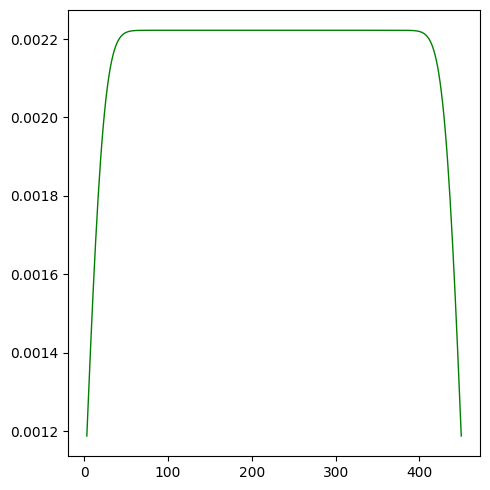

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

low_bound = Y['v'].min()
up_bound = Y['v'].max()
manual_posterior_density(Y.iloc[:,2],axes,low_bound,up_bound)

plt.tight_layout()
plt.show()

# Seaborn

In [5]:
def sns_posterior_density(X, ax, title='', color='green',alpha=1,linewidth=1):
    sns.kdeplot(X,fill=False, ax=ax, color=color,alpha=alpha,linewidth=linewidth,common_norm=True)
    #ax.set_xlim(0, ax.get_xlim()[1])
    ax.set_xlabel('X')
    ax.set_ylabel('Densidad')
    ax.set_title(title)

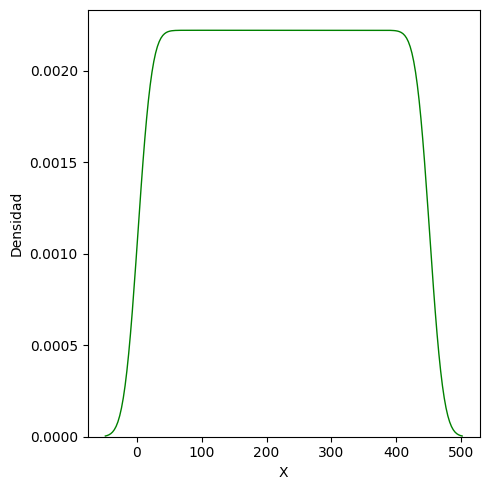

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
sns_posterior_density(Y.iloc[:,2].values,ax=ax)
plt.tight_layout();
plt.show()

# KDEpy

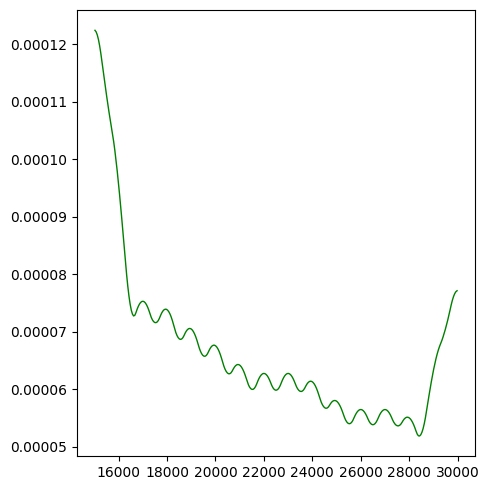

In [7]:
# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE

def KDEpy_density_plot(data, ax,title='',low_bound = None,up_bound = None, color='black',alpha=1,label='',kernel='biweight', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		kde = FFTKDE(bw=bw, kernel=kernel)
		x, y = kde.fit(data)(2**10)
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		# Compute KDE using the bandwidth found, and twice as many grid points
		x, y = FFTKDE(bw=kde.bw, kernel=kernel).fit(data)(2**10)
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		x, y = FFTKDE(bw=bw, kernel=kernel).fit(data)(200)
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
i=0
x,y,kde = KDEpy_density_plot(Y.iloc[:,i].values,ax=ax,low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(),linewidth=1,color='green')
plt.tight_layout();
plt.show()

# Scikit Learn

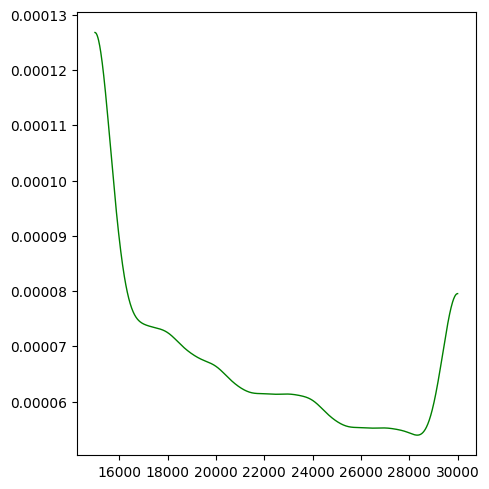

In [8]:
# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

i=0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
x,y,kde = SKL_density_plot(Y.iloc[:,i].values,ax=ax,low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(),kernel='gaussian',linewidth=1,color='green')
plt.tight_layout();
plt.show()